In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from datetime import timedelta
import imageio as io
import glob 
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from scipy import stats 

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# plt.style.use('paper.mplstyle')

# read data

In [141]:
# make a frame with station names as column and time as row
# first, make an empty frame with desired time as column

date_start = datetime.datetime(2022, 1, 15, 0, 0, 0)
date_end = datetime.datetime(2022, 1, 25, 0, 0, 0)
days = pd.date_range(date_start, date_end, freq='1min') # MUST have same granularity as txt data!

df_empty = pd.DataFrame({'time': days})

df_empty.head()

# second, insert pressure data into frame!

all_files = glob.glob('data/raw_data/*.txt')
all_files.sort()

for i in range(len(all_files)):
    df_tmp = pd.read_csv(all_files[i], header=0, skiprows=0, usecols=(0,4,5), index_col=1) # station, pressure
    # df_tmp.columns = ['station', 'pressure']
    if df_tmp.shape[0] > 0: # non empty data
        df_tmp.index = pd.DatetimeIndex(df_tmp.index)
        df_tmp = df_tmp.reindex(days, fill_value=np.nan)

        pressure_tmp = df_tmp['pres1']
        station_tmp = df_tmp['station'][0]

        df_empty[station_tmp] = pressure_tmp.values

stations_non_empty = df_empty.columns[1:].tolist()
print(f'# of non-empty stations: {len(stations_non_empty)}')

# of non-empty stations: 835


In [142]:
# get location of all stations and transform to geopandas frame
df_all_stations = pd.read_csv('data/stations_US.csv', index_col=0)

df_all_stations = gpd.GeoDataFrame(
    df_all_stations, geometry=gpd.points_from_xy(df_all_stations['lon'], df_all_stations['lat']))
print('total number of stations: ' + str(len(df_all_stations)))

all_stations = list(df_all_stations['station'])
df_all_stations.head()

total number of stations: 2792


,station,lon,lat,geometry
0,PADK,-176.6460,51.8780,POINT (-176.64600 51.87800)
1,PAKH,-154.1800,56.9400,POINT (-154.18000 56.94000)
2,PAUT,-165.6041,54.1446,POINT (-165.60410 54.14460)
3,PALP,-150.9447,70.3443,POINT (-150.94470 70.34430)
4,PAFM,-157.8575,67.1063,POINT (-157.85750 67.10630)


In [143]:
# get world map
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


# data cleaning

In [206]:
# subset?

df_series = df_empty.copy()

# date_start = datetime.datetime(2022, 1, 15, 8, 0, 0)
# date_end = datetime.datetime(2022, 1, 15, 18, 0, 0)
# df_series = df_series.loc[(pd.to_datetime(df_series['time']) > date_start) & (df_series['time'] < date_end)]

In [207]:
df_series = df_series[df_series.columns[df_series.isnull().mean() < 0.9]]
df_series.head()

stations = df_series.columns[1:]

# delete stations with no data
df_stations = df_all_stations.copy()
for s in df_stations['station']:
    if s not in stations:
        df_stations.drop(df_stations[df_stations['station']==s].index, inplace=True)
    
print(df_series.shape)
print(df_stations.shape)

(14401, 836)
(834, 4)


In [208]:
df_stations

,station,lon,lat,geometry
6,PANC,-150.0261,61.1697,POINT (-150.02610 61.16970)
16,PABE,-161.8264,60.7858,POINT (-161.82640 60.78580)
17,PABT,-151.5189,66.9165,POINT (-151.51890 66.91650)
34,PACV,-145.4511,60.4889,POINT (-145.45110 60.48890)
35,PASC,-148.4652,70.1948,POINT (-148.46520 70.19480)
...,...,...,...,...
2776,RKS,-109.0652,41.5942,POINT (-109.06520 41.59420)
2779,SHR,-106.9700,44.7700,POINT (-106.97000 44.77000)
2786,TOR,-104.1528,42.0647,POINT (-104.15280 42.06470)
2790,WRL,-107.9508,43.9657,POINT (-107.95080 43.96570)


# EDA

In [209]:
# SFO first shock: 1-15, 12:12 UTC
speed = 8426*10**3/(8*60*60)
print(speed)
print(8426*10**3/(speed) / (60*60))
print(4*10**7/(300) / (60*60))

292.56944444444446
8.0
37.03703703703704


In [210]:
forward_t = []
backward_t = []
t_errupt = pd.to_datetime('2022-01-15 04:14:00')
t_to_station = pd.to_timedelta('7 hours 0 minutes') # SFO
# t_to_station = pd.to_timedelta('9 hours 20 minutes') # MIA
t_circle = pd.to_timedelta('35 hours 0 minutes')
for i in range(0, 5):
    forward_t.append(t_errupt + t_to_station + i * t_circle)
    backward_t.append(t_errupt + t_circle - t_to_station + i * t_circle)
    
    # forward_t.append(pd.to_datetime('2022-01-15 04:30:00') + pd.to_timedelta('9 hours 20 minutes') + i * pd.to_timedelta('34 hours')) # MIA

    # forward_t.append(pd.to_datetime('2022-01-15 04:30:00') + pd.to_timedelta('8 hours') + i * pd.to_timedelta('33 hours')) # DFW
    # backward_t.append(pd.to_datetime('2022-01-15 04:30:00') + pd.to_timedelta('33 hours') - pd.to_timedelta('8 hours') + i * pd.to_timedelta('33 hours')) # DFW


In [211]:
print(forward_t)
print(backward_t)

[Timestamp('2022-01-15 11:14:00'), Timestamp('2022-01-16 22:14:00'), Timestamp('2022-01-18 09:14:00'), Timestamp('2022-01-19 20:14:00'), Timestamp('2022-01-21 07:14:00')]
[Timestamp('2022-01-16 08:14:00'), Timestamp('2022-01-17 19:14:00'), Timestamp('2022-01-19 06:14:00'), Timestamp('2022-01-20 17:14:00'), Timestamp('2022-01-22 04:14:00')]


In [216]:
# visualize pressure gradients for a station
def show_gradient(s):
    fig, ax = plt.subplots(figsize=(10,4))
    scaled = -1 + df_series[s]/df_series[s].iloc[0]
    grad = np.gradient(scaled, 3)
    scale_factor = 30
    ax.plot(df_series['time'], scaled, label='Scaled pressure', color='dodgerblue')
    ax.plot(df_series['time'], scale_factor*np.gradient(scaled, 3), '-', lw=1, label='Gradient', color='darkorange', alpha=0.5)

    t_min = df_series['time'].loc[grad == np.min(grad)] # TimeStamp corresponding to most negative change
    g_min = scale_factor*grad[grad == np.min(grad)] # Gradient corresponding to most negative change

    ax.plot(t_min, g_min, 'o', color='r')
    # t_shock.append(pd.Timestamp(t_min.values[0]))
    # dt_shock.append((pd.Timestamp(t_min.values[0]) - datetime.datetime(2022, 1, 15, 0, 0, 0)).total_seconds())

    # ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%D:%H'))
    # ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=6))

    plt.axvline(pd.to_datetime('2022-01-15 04:14:00'), linestyle='--', color='r', label='Erruption')
    
    plt.scatter(forward_t[0], -0.006, marker='^', color='m', label='Forward pass')
    plt.scatter(backward_t[0], -0.006, marker='^', color='c', label='Backward pass')
    for i in range(1, len(forward_t)):
        plt.plot(forward_t[i], -0.006, marker='^', color='m')
        plt.plot(backward_t[i], -0.006, marker='^', color='c')
    
    
    ax.set_xlabel('Time (UTC)')
    ax.set_ylabel('Relative pressure')
    # plt.ylim(-0.007,)
    plt.gcf().autofmt_xdate() # Rotation
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.title('Pressure data at airport ' + s)
    plt.show()

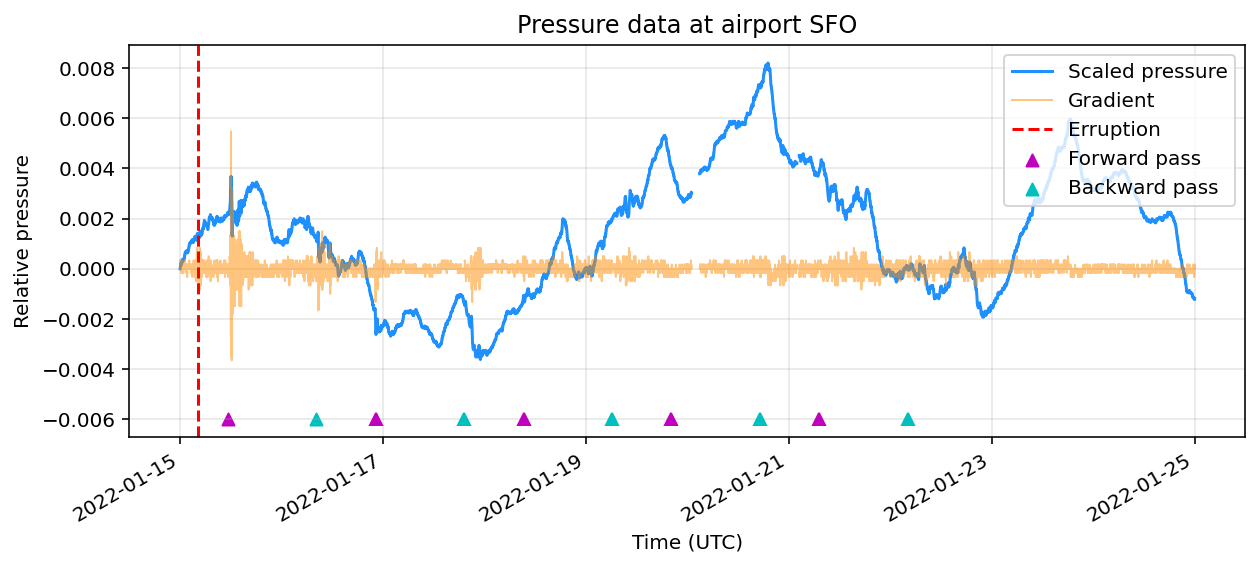

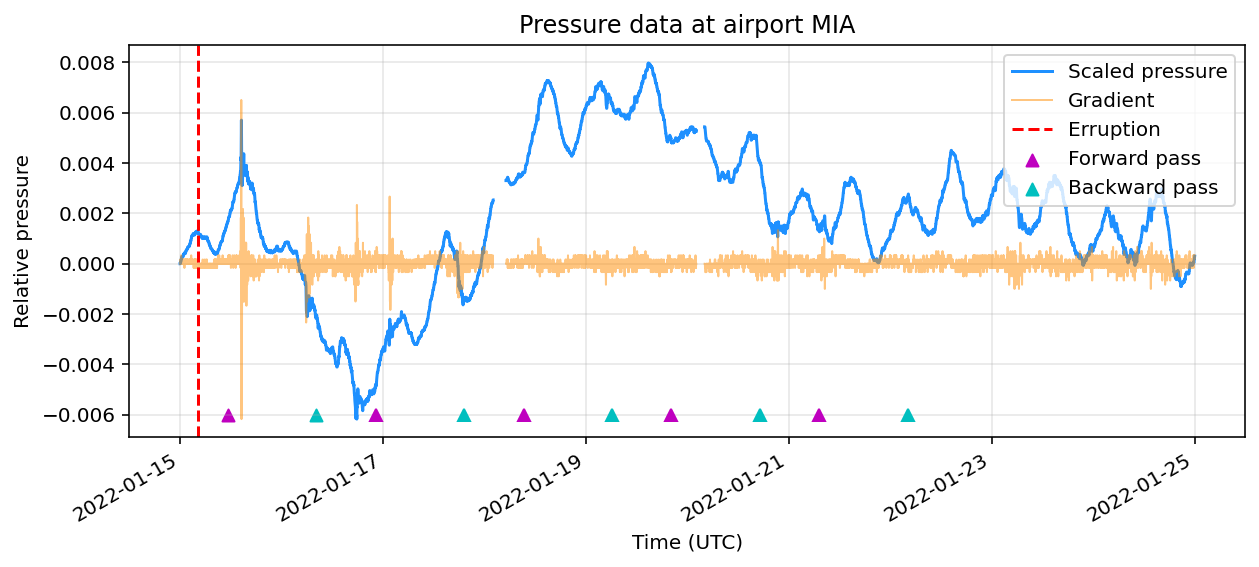

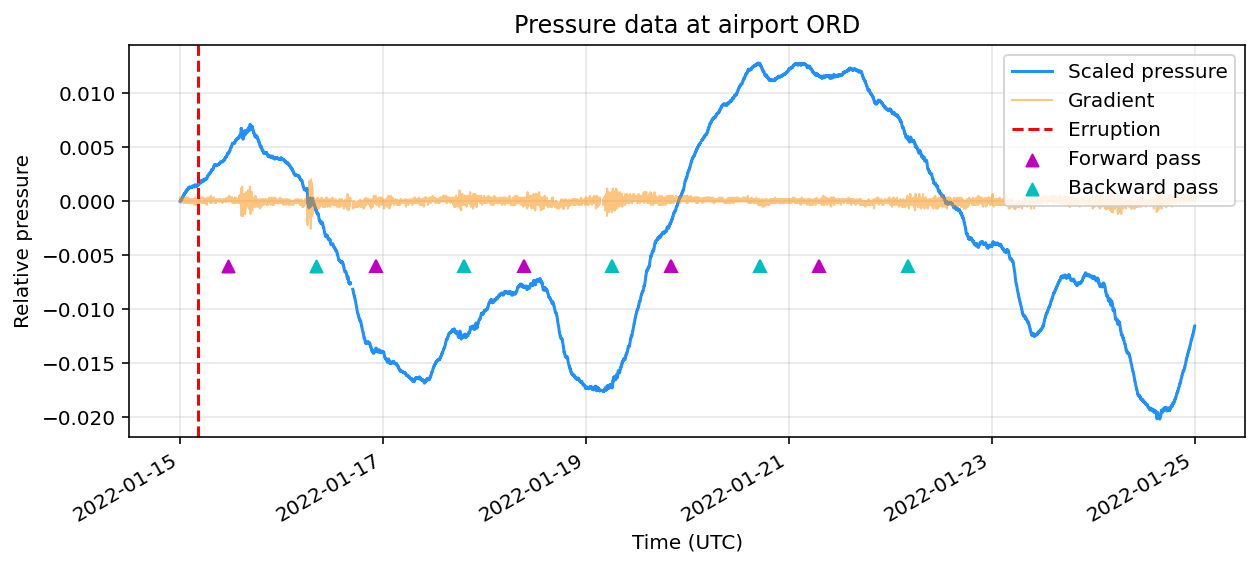

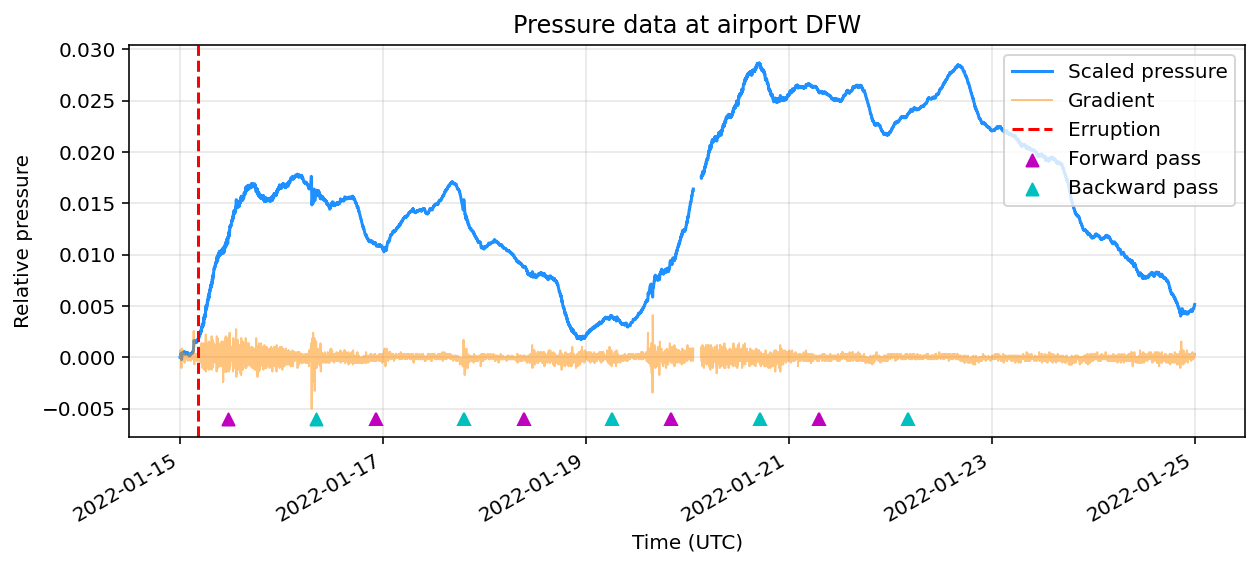

In [217]:
show_gradient('SFO')
show_gradient('MIA')
show_gradient('ORD')
show_gradient('DFW')

In [161]:
# calculate percent change and find time of shock wave arriving

t_shock = []
dt_shock = []
amplitude = []
for s in df_stations['station']:
    # changes = df_series[s].pct_change(periods=curr_period) # find percentage change
    changes = np.gradient(df_series[s], 3)
    changes[np.isnan(changes)] = 100
    t_min = df_series['time'].loc[changes == np.min(changes)] # TimeStamp corresponding to most negative change

    # plt.figure()
    # plt.plot(df_series['time'], changes)
    # plt.plot(t_min, np.min(changes), 'ro')
    # # break
    amplitude.append(np.abs(np.min(changes)))
    t_shock.append(pd.Timestamp(t_min.values[0]))
    dt_shock.append((pd.Timestamp(t_min.values[0]) - datetime.datetime(2022, 1, 15, 0, 0, 0)).total_seconds())

# create shock wave time columns
df_stations['t_shock'] = t_shock
df_stations['dt_shock'] = dt_shock
df_stations['shock_amplitude'] = amplitude
# df_stations = df_stations[df_stations['t_shock']>0]
df_stations.head()

,station,lon,lat,geometry,t_shock,dt_shock,shock_amplitude
6,PANC,-150.0261,61.1697,POINT (-150.02610 61.16970),2022-01-15 12:54:00,46440.0,0.004667
16,PABE,-161.8264,60.7858,POINT (-161.82640 60.78580),2022-01-15 12:43:00,45780.0,0.002500
17,PABT,-151.5189,66.9165,POINT (-151.51890 66.91650),2022-01-15 13:27:00,48420.0,0.002833
34,PACV,-145.4511,60.4889,POINT (-145.45110 60.48890),2022-01-15 13:00:00,46800.0,0.004333
35,PASC,-148.4652,70.1948,POINT (-148.46520 70.19480),2022-01-15 13:48:00,49680.0,0.003333


In [162]:
df_stations['t_shock'][df_stations['station']=='SFO'].values

array(['2022-01-15T12:12:00.000000000'], dtype='datetime64[ns]')

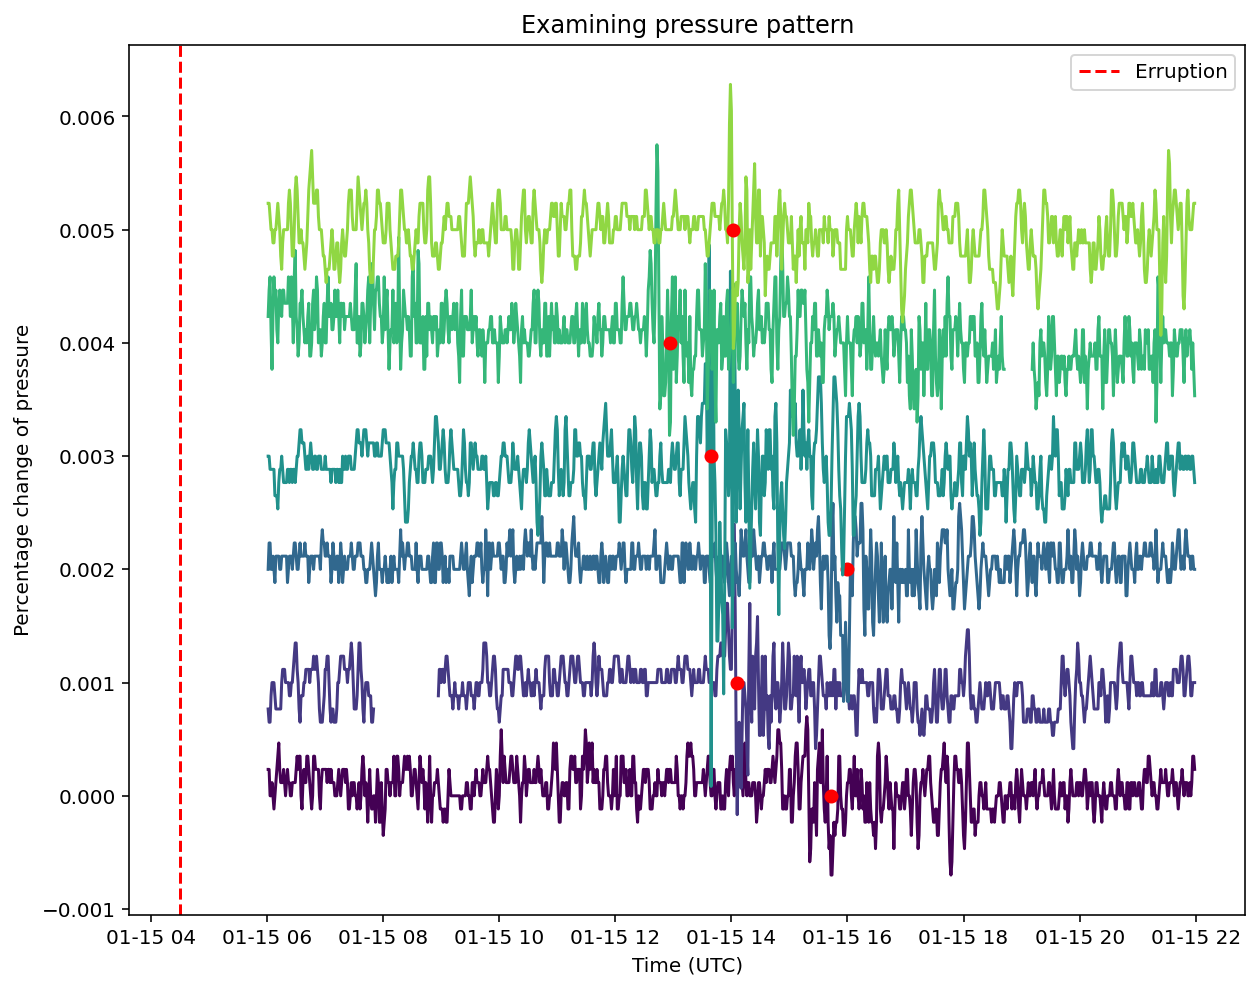

In [163]:
# visualize pressure gradients for all stations

fig, ax = plt.subplots(figsize=(10,8))
cm = matplotlib.cm.get_cmap()

n_toshow = 6
for i in range(n_toshow):
    s = stations[i]
    # ax.plot(df_series['time'], i/1000 + 0.7 * df_series[s].pct_change(periods=curr_period), color=cm(i/n_toshow))
    ax.plot(df_series['time'], i/1000 + 0.7 * np.gradient(df_series[s], 3), color=cm(i/n_toshow))

    ax.plot(df_stations[df_stations['station']==s]['t_shock'], i/1000, 'o', color='red')
# 
plt.axvline(pd.to_datetime('2022-01-15 04:30:00'), linestyle='--', color='r', label='Erruption')
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=6))
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Percentage change of pressure')
plt.title('Examining pressure pattern')
plt.legend()
# plt.xlim(datetime.datetime(2022, 1, 15, 10, 0), datetime.datetime(2022, 1, 15, 15, 0))
plt.show()

In [164]:
df_stations[df_stations['station']=='SFO']

,station,lon,lat,geometry,t_shock,dt_shock,shock_amplitude
445,SFO,-122.3749,37.619,POINT (-122.37490 37.61900),2022-01-15 12:12:00,43920.0,0.003667


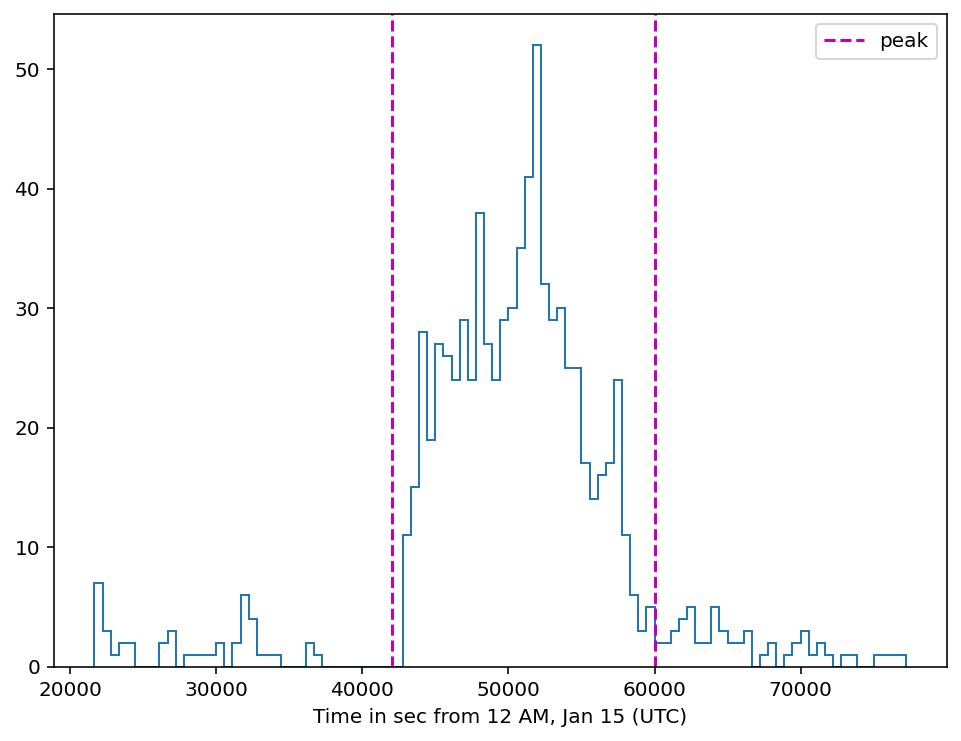

In [165]:
# distribution of shock wave time?
left = 42000 # 210000 # 42000
right = 60000 # 240000 # 60000

plt.figure(figsize=(8,6))
plt.hist(df_stations['dt_shock'],bins=100, histtype='step')
plt.axvline(left, linestyle='--', color='m')
plt.axvline(right, linestyle='--', color='m', label='peak')
plt.xlabel('Time in sec from 12 AM, Jan 15 (UTC)')
plt.legend()
plt.show()

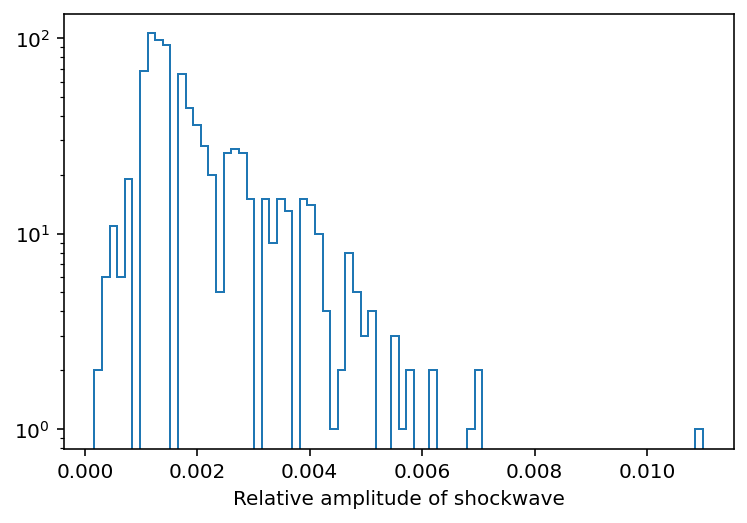

In [166]:
plt.hist(df_stations['shock_amplitude'],bins=80, histtype='step', log=True)
plt.xlabel('Relative amplitude of shockwave')
plt.show()

Text(0, 0.5, 'Relative amplitude of shockwave')

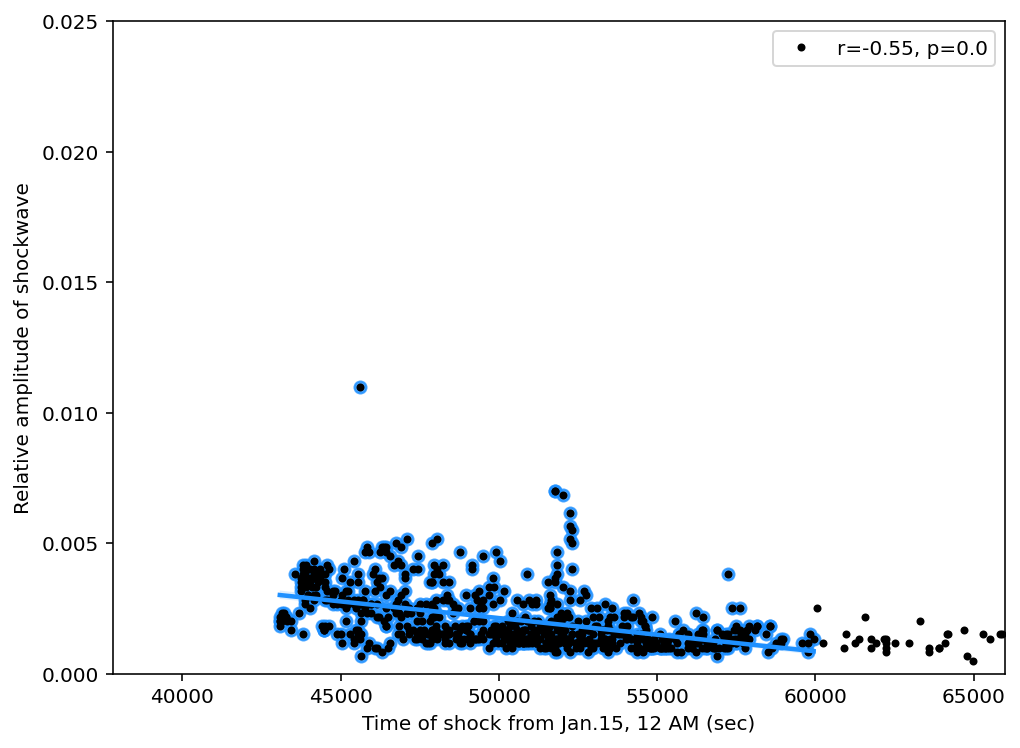

In [167]:
plt.figure(figsize=(8,6))

df_visualize = df_stations[(df_stations['dt_shock'] > left) & (df_stations['dt_shock'] < right)]
r,p= stats.spearmanr(df_visualize['dt_shock'], df_visualize['shock_amplitude'])

plt.plot(df_stations['dt_shock'], df_stations['shock_amplitude'], '.',color='black',label=f'r={np.round(r,2)}, p={np.round(p,2)}')
sns.regplot(x="dt_shock", y="shock_amplitude", data=df_visualize, color='dodgerblue')

plt.xlim(left*0.9,right*1.1)
plt.ylim(0,0.025)
plt.legend()

plt.xlabel('Time of shock from Jan.15, 12 AM (sec)')
plt.ylabel('Relative amplitude of shockwave')

# Plot shockwave propagation

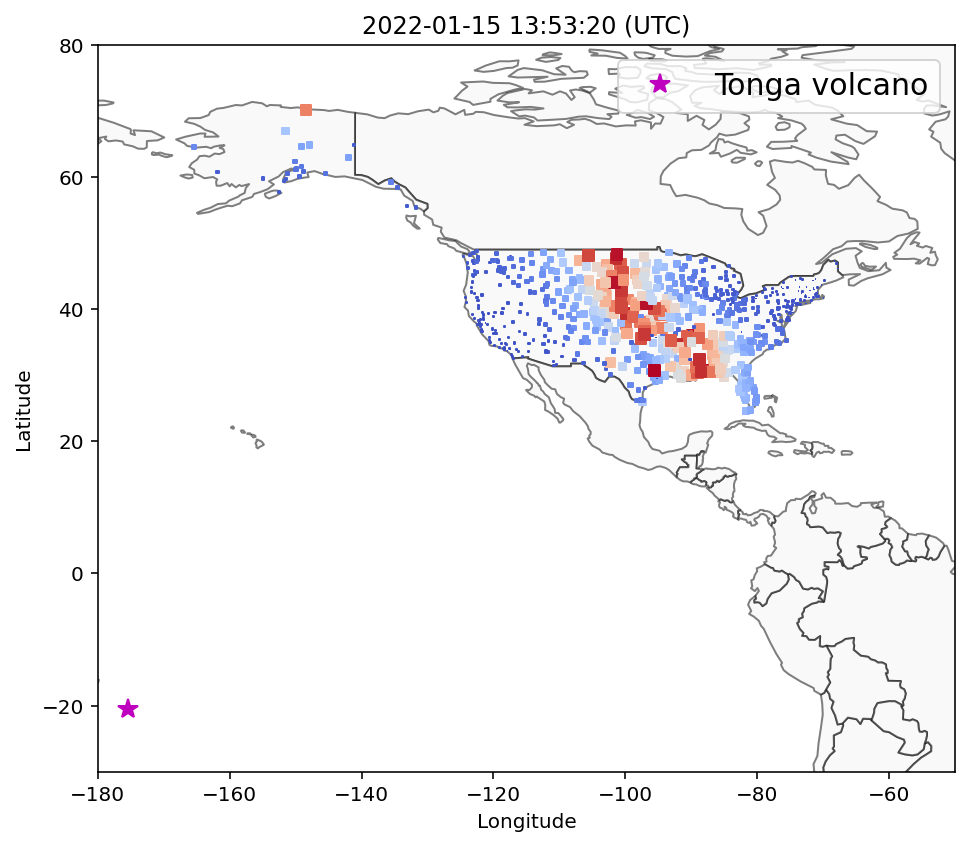

In [168]:
# save shock wave as png frames!
t = 50000

fig, ax = plt.subplots(figsize=(8,6))
cm = matplotlib.cm.get_cmap('coolwarm')
df_world.plot(ax=ax, color='whitesmoke', edgecolor='black', alpha=0.5)

cval_raw = (1 - np.abs(df_stations['dt_shock'] - t)/50000).values
cval_raw = (cval_raw - np.min(cval_raw)) / (np.max(cval_raw) - np.min(cval_raw))
cval = cval_raw ** 20
# cval = cval_raw * 1 / (1 + np.exp(-(cval_raw - 0.5)))
color = np.array([cm(i) for i in cval])
ax.scatter(df_stations['lon'],df_stations['lat'], marker='s', color=color, s=30*cval, alpha=1)
    
ax.plot(-175.385,-20.55, '*', color='m', markersize=10, label='Tonga volcano')
ax.plot()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(-180, -50)
ax.set_ylim(-30,80)
ax.set_title(str(datetime.datetime(2022, 1, 15, 0, 0, 0) + datetime.timedelta(seconds=int(t))) + ' (UTC)')
# plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend(prop={'size':15})
plt.show()

In [59]:
# # save shock wave as png frames!
# for t in np.arange(left, right, 100):

#     fig, ax = plt.subplots(figsize=(8,6))
#     cm = matplotlib.cm.get_cmap('coolwarm')
#     df_world.plot(ax=ax, color='whitesmoke', edgecolor='black', alpha=0.5)
        
#     cval_raw = (1 - np.abs(df_stations['dt_shock'] - t)/12000).values
#     cval_raw = (cval_raw - np.min(cval_raw)) / (np.max(cval_raw) - np.min(cval_raw))
#     cval = cval_raw ** 20
#     color = np.array([cm(i) for i in cval])
#     ax.scatter(df_stations['lon'],df_stations['lat'], marker='s', color=color, s=30*cval, alpha=1)

#     ax.plot(-175.385,-20.55, '*', color='m', markersize=10, label='Tonga volcano')
#     ax.plot()
#     ax.set_xlabel('Longitude')
#     ax.set_ylabel('Latitude')
#     ax.set_xlim(-180, -50)
#     ax.set_ylim(-30,80)
#     ax.set_title(str(datetime.datetime(2022, 1, 15, 0, 0, 0) + datetime.timedelta(seconds=int(t))) + ' (UTC)')
#     plt.tight_layout()
#     plt.legend(prop={'size':15})
    
#     plt.savefig('data_animation/frame_' +str(t).zfill(2) + '.png', dpi=150)
#     plt.close()

In [60]:
# # save png as movie
# images = []
# fs = glob.glob('data_animation/frame_*.png')
# fs.sort()
# for f in fs:
#     images.append(io.imread(f))
    
# io.mimsave('final_cut.gif', images, fps=40)